<a href="https://colab.research.google.com/github/Srishti6125/Waste-Classification-CNN-EfficientNetB0/blob/main/Waste_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##training model

In [ ]:
# importing libraries
import kagglehub, os, json, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Download dataset
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
data_dir = os.path.join(path, "garbage_classification")
print(f"Corrected data_dir: {data_dir}")

Using Colab cache for faster access to the 'garbage-classification' dataset.
Corrected data_dir: /kaggle/input/garbage-classification/garbage_classification


In [ ]:
# checking subfolders
print(os.listdir(data_dir))

['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']


In [ ]:
# checking for number of images in each class
from collections import Counter
class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])
        class_counts[class_name] = num_images

print("Images per class:")
for cls, count in sorted(class_counts.items()):
    print(f"{cls}: {count}")


Images per class:
battery: 945
biological: 985
brown-glass: 607
cardboard: 891
clothes: 5325
green-glass: 629
metal: 769
paper: 1050
plastic: 865
shoes: 1977
trash: 697
white-glass: 775


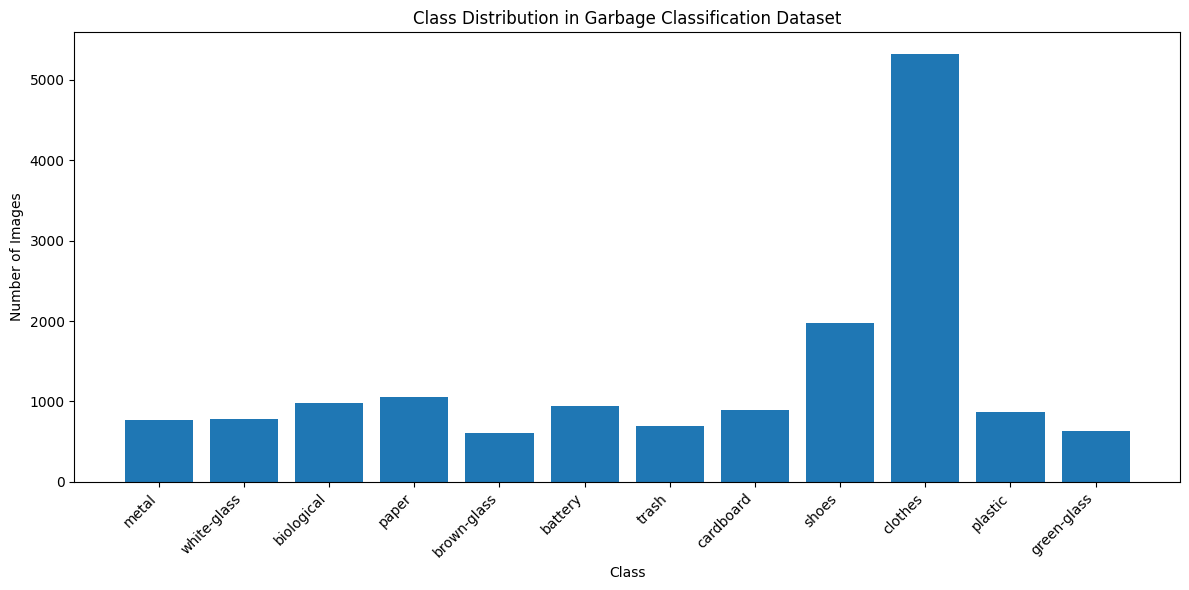

In [ ]:
# plot of class distribution
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution in Garbage Classification Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

In [ ]:
# Defining image size, batch size, and seed
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [ ]:
# splitting data into training, validation and test set

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,       # 20% goes into TEMP
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
val_size = 0.5   # 50% of temp_ds → validation (10% of full data)
test_size = 0.5  # 50% of temp_ds → test (10% of full data)

val_ds = temp_ds.take(int(len(temp_ds) * val_size))
test_ds = temp_ds.skip(int(len(temp_ds) * val_size))

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [ ]:
# Inspect dataset summary
class_names = train_ds.class_names
num_classes = len(class_names)

print("Class names:", class_names)
print("Num classes:", num_classes)
print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))
print("Test batches:", len(test_ds))

# Inspect shapes from one batch
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    break

Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Num classes: 12
Train batches: 388
Val batches: 48
Test batches: 49
Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 12)


In [ ]:
#Prefetch + shuffle for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

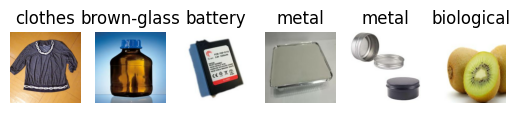

In [ ]:
# visualizing some images
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(1,6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = tf.argmax(labels[i]).numpy()
        plt.title(class_names[class_index])
        plt.axis("off")

In [ ]:
# data augmentation
data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.1),
        layers.RandomContrast(0.2), layers.RandomBrightness(0.2), layers.RandomSaturation(0.2) ],
    name="data_augmentation"
)

In [ ]:
INPUT_SHAPE = IMG_SIZE + (3,)   # (224, 224, 3)

# Base model: pre-trained EfficientNetB0 without top classifier
base_model = EfficientNetB0(
    include_top=False,        # remove original ImageNet classifier
    weights="imagenet",       # use pretrained weights
    input_shape=INPUT_SHAPE
)

base_model.trainable = False    # Freeze backbone for initial training

# Input layer
inputs = layers.Input(shape=INPUT_SHAPE, name="input_image")

# Data augmentation
x = data_augmentation(inputs)

# Preprocessing for EfficientNet (scales pixels correctly)
x = preprocess_input(x)

# Passing through EfficientNet backbone
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)    # Global pooling to get a 1D vector

# Regularization to avoid overfitting
x = layers.Dropout(0.3, name="top_dropout")(x)

# Final classification layer: 12 outputs, one per class
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

# Building the model
model = models.Model(inputs, outputs, name="efficientnet_garbage_classifier")

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnet_garbage_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,064,943 (15.51 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# compiling model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# defining weights for each class
total_images = sum(class_counts.values())
class_weight = {}

for idx, class_name in enumerate(class_names):
    count = class_counts[class_name]
    class_weight[idx] = total_images / (num_classes * count)

print("Class weights:")
for i, w in class_weight.items():
    print(f"{i} ({class_names[i]}): {w:.3f}")

Class weights:
0 (battery): 1.368
1 (biological): 1.313
2 (brown-glass): 2.130
3 (cardboard): 1.451
4 (clothes): 0.243
5 (green-glass): 2.056
6 (metal): 1.681
7 (paper): 1.231
8 (plastic): 1.495
9 (shoes): 0.654
10 (trash): 1.855
11 (white-glass): 1.668


In [ ]:
# early stopping
early_stop = EarlyStopping(
    monitor="val_loss",          # what to watch
    patience=3,                  # how many epochs to wait with no improvement
    restore_best_weights=True,   # go back to best model weights
    verbose=1
)

In [ ]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[early_stop]
)

Epoch 1/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - accuracy: 0.6697 - loss: 1.3692 - val_accuracy: 0.9160 - val_loss: 0.3015
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.8627 - loss: 0.5942 - val_accuracy: 0.9368 - val_loss: 0.2301
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.8800 - loss: 0.5076 - val_accuracy: 0.9414 - val_loss: 0.2048
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.8938 - loss: 0.4686 - val_accuracy: 0.9453 - val_loss: 0.1991
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step - accuracy: 0.8938 - loss: 0.4300 - val_accuracy: 0.9414 - val_loss: 0.1971
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.9013 - loss: 0.4201 - val_accuracy: 0.9518 - val_loss: 0.1764
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - accuracy: 0.9080 - loss: 0.3875 - val_accuracy: 0.9434 - val_loss: 0.1763
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.9031 - loss: 0.3995 - 

In [ ]:
# saving pre-tuned model
model.save("efficientnet_stage1_final.keras")

In [ ]:
# saving class names
with open("class_names.json","w") as f:
    json.dump(class_names, f)

In [ ]:
# evaluation on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.9567 - loss: 0.1569
Test Loss: 0.1597
Test Accuracy: 0.9566


In [ ]:
# prediction on first 5 test data

# Get one batch from test set
test_images, test_labels = next(iter(test_ds))

# Select first 10 images
sample_images = test_images[:5]
sample_labels = test_labels[:5]

# Run prediction
pred_probs = model.predict(sample_images)   # shape: (5, 12)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(sample_labels.numpy(), axis=1)

print("\n===== Predictions on first 5 test images =====\n")
for i in range(5):
    print(f"Image {i+1}:")
    print(f"  True label:      {class_names[true_classes[i]]}")
    print(f"  Predicted label: {class_names[pred_classes[i]]}")
    print(f"  Confidence:      {pred_probs[i][pred_classes[i]]:.3f}")
    print("-" * 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

===== Predictions on first 5 test images =====

Image 1:
  True label:      biological
  Predicted label: biological
  Confidence:      0.998
----------------------------------------
Image 2:
  True label:      shoes
  Predicted label: shoes
  Confidence:      1.000
----------------------------------------
Image 3:
  True label:      battery
  Predicted label: battery
  Confidence:      0.791
----------------------------------------
Image 4:
  True label:      clothes
  Predicted label: clothes
  Confidence:      1.000
----------------------------------------
Image 5:
  True label:      clothes
  Predicted label: clothes
  Confidence:      0.999
----------------------------------------


Why do we unfreeze only deeper layers?

Because:
- early layers learn generic things → edges, shadows, which don't need to change
- deeper layers learn dataset-specific patterns → glass reflections, metal texture, fabric wrinkles.
Those deeper layers must adapt to your garbage dataset

In [ ]:
# fine tuning efficientnet
base_model.trainable = True  # unfreezing base model

# freezing all layers except the last 40
for layer in base_model.layers[:-40]:
    layer.trainable = False

print(f"Total layers in base_model: {len(base_model.layers)}")
trainable_count = np.sum([layer.trainable for layer in base_model.layers])
print(f"Trainable layers in base_model after unfreezing: {trainable_count}")

Total layers in base_model: 238
Trainable layers in base_model after unfreezing: 40


In [ ]:
# recompiling with smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Fine-tune training with EarlyStopping
fine_tune_early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

fine_tune_epochs = 10
initial_epoch = len(history.history["loss"])

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epoch + fine_tune_epochs,
    initial_epoch=initial_epoch,
    class_weight=class_weight,
    callbacks=[fine_tune_early_stop]
)

Epoch 14/23
388/388 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - accuracy: 0.8136 - loss: 0.6284 - val_accuracy: 0.9154 - val_loss: 0.3116
Epoch 15/23
388/388 ━━━━━━━━━━━━━━━━━━━━ 56s 104ms/step - accuracy: 0.8146 - loss: 0.6530 - val_accuracy: 0.9160 - val_loss: 0.3157
Epoch 16/23
388/388 ━━━━━━━━━━━━━━━━━━━━ 61s 111ms/step - accuracy: 0.8288 - loss: 0.5960 - val_accuracy: 0.9154 - val_loss: 0.3050
Epoch 17/23
388/388 ━━━━━━━━━━━━━━━━━━━━ 56s 104ms/step - accuracy: 0.8299 - loss: 0.5954 - val_accuracy: 0.9173 - val_loss: 0.3009
Epoch 18/23
388/388 ━━━━━━━━━━━━━━━━━━━━ 55s 104ms/step - accuracy: 0.8276 - loss: 0.6125 - val_accuracy: 0.9180 - val_loss: 0.3018
Epoch 19/23
388/388 ━━━━━━━━━━━━━━━━━━━━ 55s 104ms/step - accuracy: 0.8357 - loss: 0.5811 - val_accuracy: 0.9206 - val_loss: 0.2877
Epoch 20/23
388/388 ━━━━━━━━━━━━━━━━━━━━ 56s 105ms/step - accuracy: 0.8376 - loss: 0.5737 - val_accuracy: 0.9225 - val_loss: 0.2901
Epoch 21/23
388/388 ━━━━━━━━━━━━━━━━━━━━ 55s 105ms/step - accuracy: 0.8424 -

In [ ]:
# saving tuned model
model.save("efficientnet_finetuned_best.keras")

In [ ]:
# re-evaluating on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Loss after fine-tuning: {test_loss:.4f}")
print(f" Test Accuracy after fine-tuning: {test_acc:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9137 - loss: 0.3049

Test Loss after fine-tuning: 0.2715
 Test Accuracy after fine-tuning: 0.9253


In [ ]:
#Classification Report
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)            # (batch_size, 12)
    y_pred.extend(np.argmax(preds, axis=1))  # predicted class index
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # true class index
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

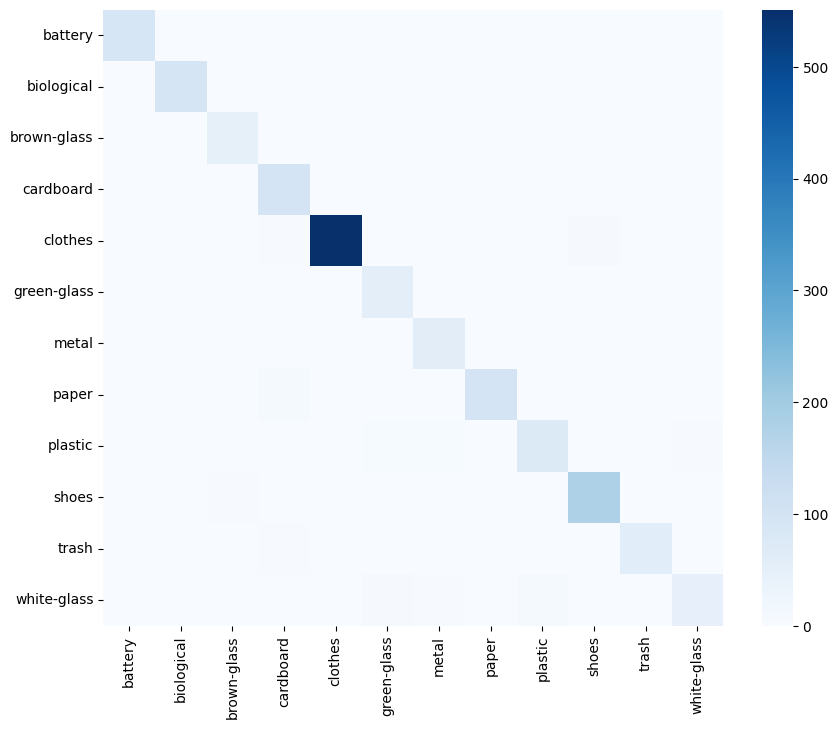

In [ ]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.show()

**📌 Final Model Selection**

We trained two versions of an EfficientNetB0 classifier:

- Stage-1: Frozen EfficientNet backbone
- Stage-2: Fine-tuned top convolution layers

After evaluation on the held-out test set:
- Stage-1 Accuracy: 95.66%
- Stage-2 Accuracy: 92.53%

The pretrained frozen model performed better and showed better generalization.
Therefore, the Stage-1 model is selected as the final and deployment-ready model.

The chosen model file: "efficientnet_stage1_final.keras"

In [ ]:
from google.colab import files

In [ ]:
# saving and downloading final model
model.save("/content/drive/MyDrive/Colab Notebooks/projects/waste classifier/efficientnet_stage1_final.keras")
files.download("efficientnet_stage1_final.keras")

print(" Model saved and downloaded succesfully.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Model saved and downloaded succesfully.


In [ ]:
# saving and downloading class names
import shutil
shutil.copy("class_names.json", "/content/drive/MyDrive/Colab Notebooks/projects/waste classifier/class_names.json")
files.download("class_names.json")

print (" class names saved and downloaded succesfully.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 class names saved and downloaded succesfully.


##loading final model

In [ ]:
# loading model and classnames
import json
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Colab Notebooks/projects/waste classifier/efficientnet_stage1_final.keras")

with open("/content/drive/MyDrive/Colab Notebooks/projects/waste classifier/class_names.json") as f:
    class_names = json.load(f)

print("Model + class names loaded successfully!")

Model + class names loaded successfully!


##predicting image

In [ ]:
import requests
from io import BytesIO
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_image(image_source):
    """
    image_source: local file path OR direct image URL
    """

    # Load image (URL or local)
    if image_source.startswith("http"):
        response = requests.get(image_source)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize(IMG_SIZE)
    else:
        img = tf.keras.utils.load_img(image_source, target_size=IMG_SIZE)

    # Display image
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    # Preprocess
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = float(np.max(predictions[0]))

    print(f"🗑️ Predicted Waste Type: {predicted_class}")
    print(f"🔍 Confidence: {confidence:.2f}")

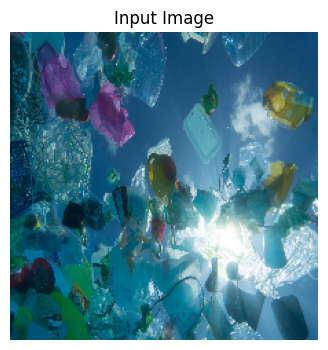

🗑️ Predicted Waste Type: plastic
🔍 Confidence: 0.47


In [ ]:
predict_image("/content/drive/MyDrive/Colab Notebooks/projects/waste classifier/pl.jpeg")

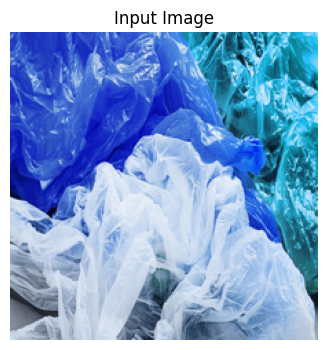

🗑️ Predicted Waste Type: metal
🔍 Confidence: 0.53


In [ ]:
predict_image("https://images.ctfassets.net/wg1141eg84ns/iundm4IZVtbL0QaUDrFZh/a1a5ee524985074836f7c1986cad497a/shutterstock_1625950732-edit__1_.jpg?fit=fill&f=center&w=1600&h=900")

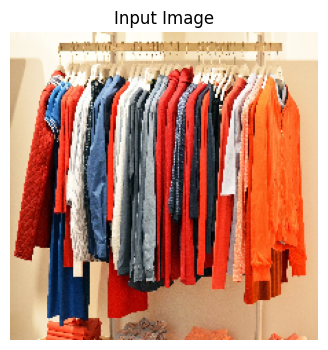

🗑️ Predicted Waste Type: clothes
🔍 Confidence: 0.92


In [ ]:
predict_image("/content/drive/MyDrive/Colab Notebooks/projects/waste classifier/c1.jpeg")

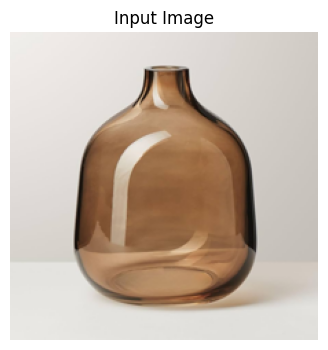

🗑️ Predicted Waste Type: brown-glass
🔍 Confidence: 0.99


In [ ]:
predict_image("https://m.media-amazon.com/images/I/61cxrKWRDOL._AC_UF894,1000_QL80_.jpg")

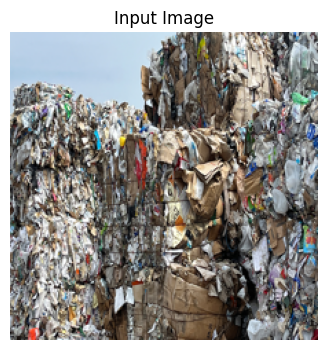

🗑️ Predicted Waste Type: cardboard
🔍 Confidence: 0.24


In [ ]:
predict_image("https://commonreader.wustl.edu/app/uploads/2023/06/TrashFormatted.jpg")

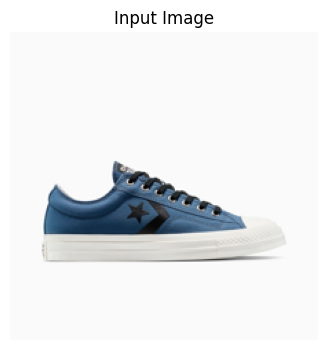

🗑️ Predicted Waste Type: shoes
🔍 Confidence: 0.98


In [ ]:
predict_image("https://converse.static.n7.io/media/catalog/product/cache/c2eb1f0db702462ce5dab3d57b75c6e4/a/1/a13246c_a_107x1-web.jpg")